In [97]:
import numpy as np
import pyuvdata
import os
import matplotlib.pyplot as plt
import sys
sys.path.append("/home/rbyrne/rlb_hera")
import plot_delay_spectra
import importlib
importlib.reload(plot_delay_spectra)
from newcal import calibration_wrappers, calibration_optimization, caldata

In [26]:
data = pyuvdata.UVData()
data.read(
   "/safepool/rbyrne/hera_data/H6C-data/2459861/zen.2459861.45004.sum.abs_calibrated.red_avg.uvh5"
)
#data.read(
#   "/safepool/rbyrne/hera_cal_testing_Sept2024/zen.2459861.45004_abscal_Sept23.uvfits"
#)
model = pyuvdata.UVData()
model.read(
  "/safepool/rbyrne/hera_data/simulated_model_vis/zen.2459861.45004.fftvis_sim.uvfits"
)
# model.read(
#  "/safepool/rbyrne/hera_data/H4C-Abscal-Model/zen.2458894.09630.uvh5"
# )
# model.read(
#   "/safepool/rbyrne/hera_data/interpolated_models/zen.2459861.45004.sum.abs_calibrated.red_avg_model.uvfits"
# )

antenna_diameters are not set or are being overwritten. antenna_diameters are set using values from known telescopes for HERA.


In [27]:
data.select(ant_str="cross")
model.select(ant_str="cross")

In [28]:
# Reduce frequencies to range where model is accurate and flagging is minimal
min_freq_hz = 108e6
max_freq_hz = 200e6
data.select(frequencies=[freq for freq in data.freq_array if (freq>min_freq_hz) and (freq<max_freq_hz)])
model.select(frequencies=[freq for freq in model.freq_array if (freq>min_freq_hz) and (freq<max_freq_hz)])

In [29]:
use_time = np.max(data.time_array)
data.select(times=use_time)
model_times = list(set(model.time_array))
model.select(
    times=model_times[
        np.where(np.abs(model_times - use_time) == np.min(np.abs(model_times - use_time)))[0][0]
    ]
)

In [30]:
data.data_array[np.where(data.flag_array)] = np.nan
#data.set_uvws_from_antenna_positions(update_vis=False)
model.set_uvws_from_antenna_positions(update_vis=False)

Recalculating uvw_array without adjusting visibility phases -- this can introduce significant errors if used incorrectly.


In [31]:
data.phase_to_time(np.mean(data.time_array))
model.phase_to_time(np.mean(data.time_array))

In [32]:
data.inflate_by_redundancy(use_grid_alg=True)
model.inflate_by_redundancy(use_grid_alg=True)

Missing some redundant groups. Filling in available data.
Missing some redundant groups. Filling in available data.


In [33]:
data.conjugate_bls()
model.conjugate_bls()

In [34]:
data_baselines = list(set(zip(data.ant_1_array, data.ant_2_array)))
model_baselines = list(set(zip(model.ant_1_array, model.ant_2_array)))
use_baselines = [baseline for baseline in data_baselines if baseline in model_baselines]
use_pols = np.intersect1d(data.polarization_array, model.polarization_array)
print(len(use_baselines))
print(len(data_baselines))

40570
40570


In [35]:
data.select(bls=use_baselines, polarizations=use_pols)
model.select(bls=use_baselines, polarizations=use_pols)

In [36]:
data.reorder_blts()
model.reorder_blts()
data.reorder_pols(order="AIPS")
model.reorder_pols(order="AIPS")
data.reorder_freqs(channel_order="freq")
model.reorder_freqs(channel_order="freq")

In [37]:
# Confirm data ordering matches:
print(np.max(np.abs(data.ant_1_array - model.ant_1_array)))
print(np.max(np.abs(data.ant_2_array - model.ant_2_array)))
print(np.max(np.abs(data.freq_array - model.freq_array)))
print(np.max(np.abs(data.time_array - model.time_array)))
print(np.max(np.abs(data.polarization_array - model.polarization_array)))

0
0
0.0
0.0
0


In [38]:
print(np.max(np.abs(data.uvw_array[:, :2] - model.uvw_array[:, :2])))

0.010023917976589303


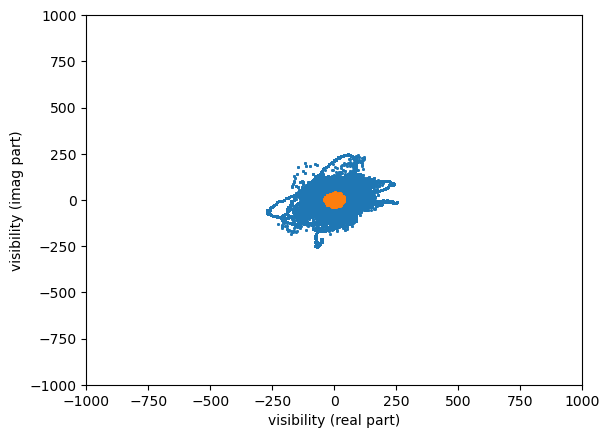

In [39]:
plt.scatter(np.real(data.data_array), np.imag(data.data_array), 1, marker=".")
plt.scatter(np.real(model.data_array), np.imag(model.data_array), 1, marker=".")
plt.xlabel("visibility (real part)")
plt.ylabel("visibility (imag part)")
plt.xlim([-1000, 1000])
plt.ylim([-1000, 1000])
plt.show()

In [40]:
model.uvw_array = data.uvw_array
data.compress_by_redundancy(use_grid_alg=True)
model.compress_by_redundancy(use_grid_alg=True)

In [41]:
print(np.nanmean(np.abs(data.data_array)))
print(np.nanmean(np.abs(data.data_array - model.data_array)))

19.9200664203469
13.470217556200472


In [42]:
data_baselines = list(set(zip(data.ant_1_array, data.ant_2_array)))
model_baselines = list(set(zip(model.ant_1_array, model.ant_2_array)))
print(data_baselines)
print(model_baselines)

[(0, 158), (11, 158), (155, 190), (5, 65), (36, 80), (22, 145), (0, 5), (2, 176), (34, 156), (109, 159), (0, 14), (65, 134), (9, 81), (22, 163), (5, 92), (0, 23), (49, 135), (22, 181), (129, 155), (151, 155), (10, 36), (98, 158), (6, 331), (2, 50), (0, 117), (22, 28), (63, 155), (0, 135), (22, 46), (155, 167), (135, 161), (6, 187), (1, 81), (22, 140), (6, 34), (64, 155), (0, 9), (9, 76), (22, 158), (34, 160), (109, 163), (6, 61), (10, 22), (132, 155), (8, 98), (0, 94), (98, 162), (2, 36), (0, 103), (8, 116), (0, 112), (22, 23), (0, 121), (22, 32), (0, 130), (94, 155), (135, 156), (155, 171), (1, 76), (4, 109), (116, 161), (127, 161), (65, 97), (22, 126), (2, 166), (65, 115), (0, 233), (22, 144), (109, 158), (6, 47), (22, 162), (17, 331), (28, 331), (6, 65), (36, 164), (47, 164), (2, 22), (0, 89), (98, 157), (0, 98), (1, 215), (5, 176), (0, 116), (22, 27), (3, 23), (155, 166), (135, 160), (116, 156), (7, 11), (127, 156), (22, 121), (5, 50), (66, 155), (0, 219), (46, 335), (21, 22), (22,

Mean of empty slice


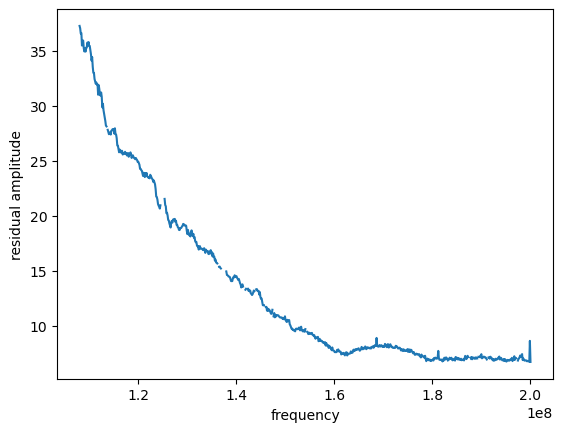

In [43]:
plt.plot(
    data.freq_array, np.nanmean(np.abs(data.data_array - model.data_array), axis=(0, 2))
)
plt.xlabel("frequency")
plt.ylabel("residual amplitude")
plt.show()

Mean of empty slice


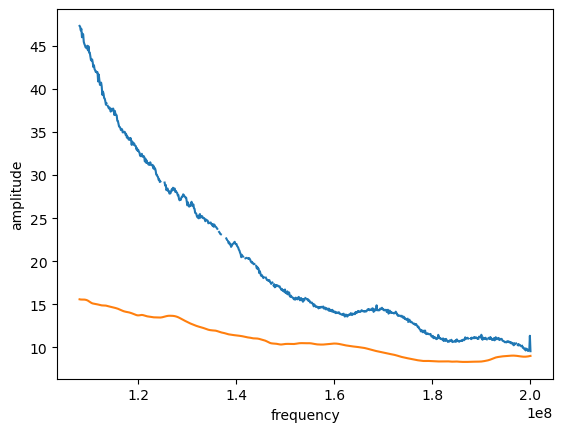

In [44]:
plt.plot(
    data.freq_array, np.nanmean(np.abs(data.data_array), axis=(0, 2))
)
plt.plot(model.freq_array, np.nanmean(np.abs(model.data_array), axis=(0, 2)))
plt.xlabel("frequency")
plt.ylabel("amplitude")
plt.show()

Mean of empty slice
Mean of empty slice


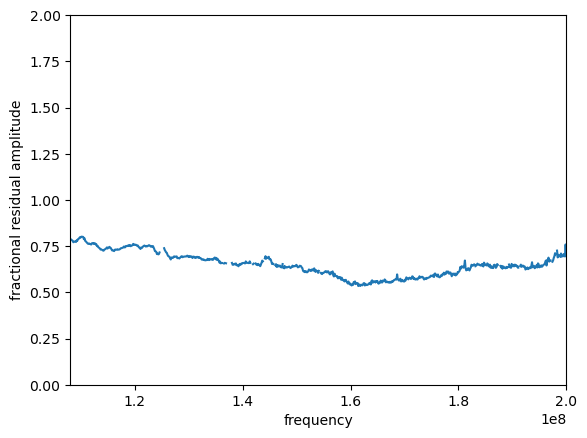

In [ ]:
plt.plot(
    data.freq_array,
    np.nanmean(np.abs(data.data_array - model.data_array), axis=(0, 2))
    / np.nanmean(np.abs(data.data_array), axis=(0, 2)),
)
plt.xlabel("frequency")
plt.ylabel("fractional residual amplitude")
plt.ylim([0,2])
#plt.xlim([108e6, 200e6])
plt.show()

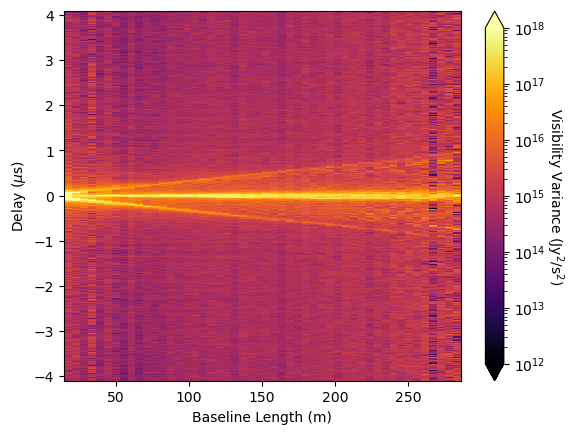

In [86]:
plot_delay_spectra.plot_visibilities(data, vmin=1e12, vmax=1e18)

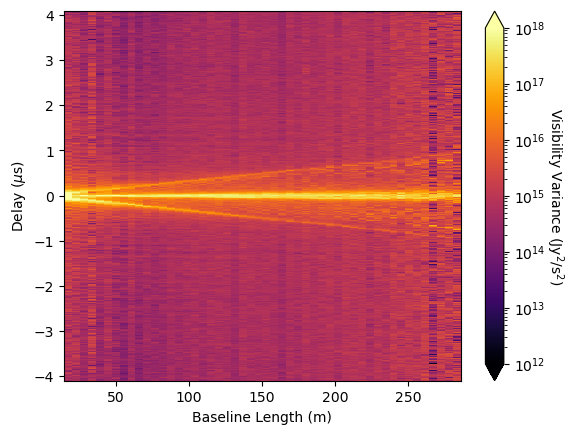

In [87]:
plot_delay_spectra.plot_visibilities(data, vmin=1e12, vmax=1e18, use_gpr=False)

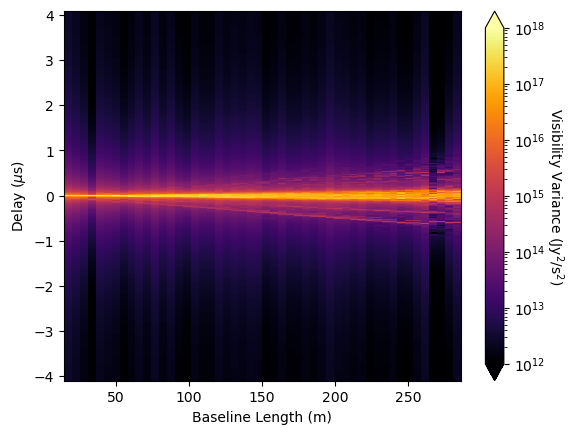

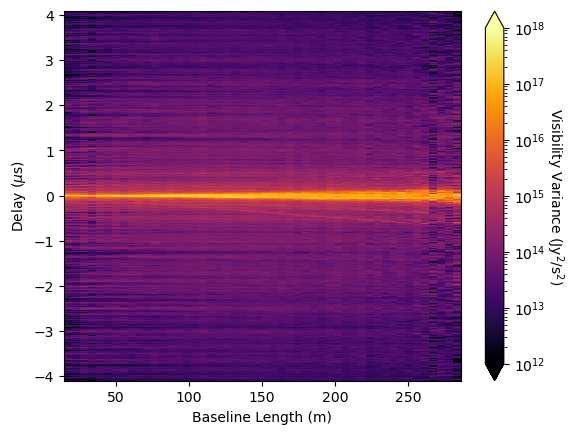

In [98]:
model.flag_array[:,:,:] = False
plot_delay_spectra.plot_visibilities(model, vmin=1e12, vmax=1e18, use_gpr=True)
model_flagged = model.copy()
model_flagged.flag_array = data.flag_array
plot_delay_spectra.plot_visibilities(model_flagged, vmin=1e12, vmax=1e18, use_gpr=True)

In [ ]:
data.filename = [""]
model.filename = [""]
diff = data.sum_vis(
    model,
    difference=True,
    inplace=False,
    override_params=[
        "timesys",
        "filename",
        "nsample_array",
        "flag_array",
        "earth_omega",
        "rdate",
        "uvw_array",
        "phase_center_catalog",
        "telescope",
        "phase_center_id_array",
        "gst0",
        "dut1",
    ],
)

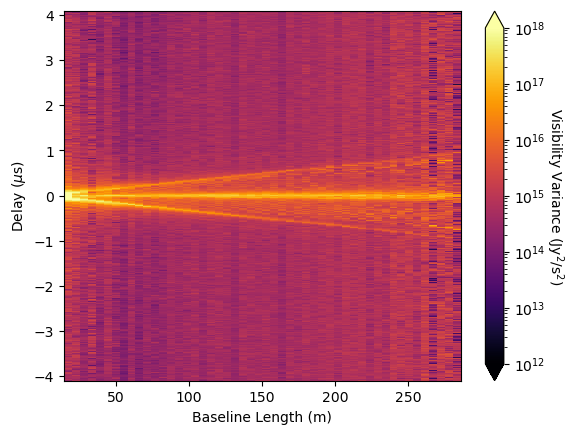

In [ ]:
plot_delay_spectra.plot_visibilities(diff, vmin=1e12, vmax=1e18)

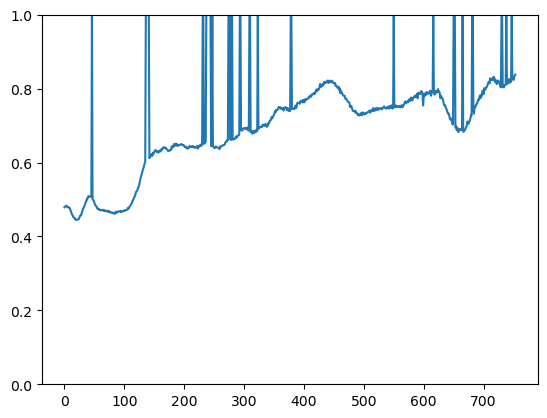

In [ ]:
abscal_params = np.load(
    "/safepool/rbyrne/hera_cal_testing_Sept2024/abscal_params_Sept23.npy"
)
plt.plot(abscal_params[0, :, 0])
plt.ylim([0,1])
plt.show()

In [ ]:
data_single_freq = data.select(frequencies=[data.freq_array[int(1536/2)]], inplace=False)
model_single_freq = model.select(frequencies=[data.freq_array[int(1536 / 2)]], inplace=False)

IndexError: index 768 is out of bounds for axis 0 with size 754

In [ ]:
print(np.nanmean(np.abs(data_single_freq.data_array)))
print(np.nanmean(np.abs(data_single_freq.data_array - model_single_freq.data_array)))
print(
    np.nanmean(np.abs(data_single_freq.data_array - model_single_freq.data_array))
    / np.nanmean(np.abs(data_single_freq.data_array))
)

22.939343043653714
15.171198771697437
0.6613615195006478


In [ ]:
data_single_freq.data_array[np.where(~np.isfinite(data_single_freq.data_array))] = 0.
abscal_params = calibration_wrappers.abscal_wrapper(
    data_single_freq,
    model_single_freq,
    log_file_path=None,
    verbose=True,
    xtol=1e-7,
    maxiter=100,
)

Formatting data...


KeyboardInterrupt: 

In [ ]:
print(abscal_params)

[[[ 0.64807327  0.60865152]]

 [[-0.0018664  -0.00138227]]

 [[ 0.00074608 -0.00562534]]]


In [ ]:
abscal_data = calibration_wrappers.apply_abscal(
    data_single_freq, abscal_params, data_single_freq.polarization_array, inplace=False
)

In [ ]:
abscal_data.data_array[np.where(abscal_data.flag_array)] = np.nan
model_single_freq.data_array[np.where(abscal_data.flag_array)] = np.nan
print(np.nanmean(np.abs(abscal_data.data_array)))
print(np.nanmean(np.abs(abscal_data.data_array - model_single_freq.data_array)))
print(np.nanmean(np.abs(abscal_data.data_array - model_single_freq.data_array))/np.nanmean(np.abs(abscal_data.data_array)))

9.053103439460527
6.783694965339086
0.7493225953622071


In [ ]:
data_single_freq.data_array[np.where(data_single_freq.flag_array)] = np.nan
print(np.nanmean(np.abs(data_single_freq.data_array)))
print(np.nanmean(np.abs(model_single_freq.data_array)))
print(
    np.nanmean(np.abs(model_single_freq.data_array))
    / np.nanmean(np.abs(data_single_freq.data_array))
)
print(
    np.nanmean(
        np.abs(abscal_data.data_array - model_single_freq.data_array * 0.62**2.)
    )
    / np.nanmean(np.abs(abscal_data.data_array))
)

22.939343043653714
12.031329421093513
0.5244844805798413
0.6347994731794205


In [ ]:
np.nanmean(np.abs(abscal_data.data_array - model_single_freq.data_array * 0.62**2.0))

5.746905294008342

In [ ]:
np.nanmean(np.abs(data_single_freq.data_array - model_single_freq.data_array))

15.171198771697437

divide by zero encountered in scalar divide


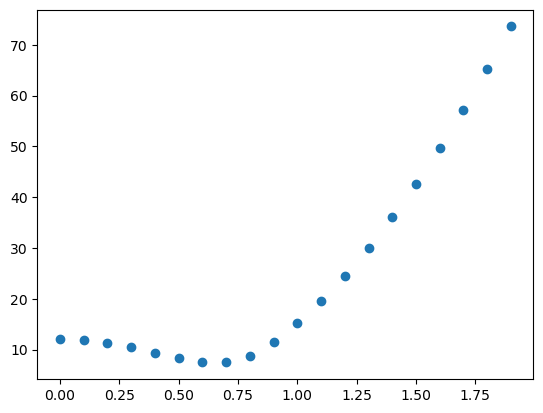

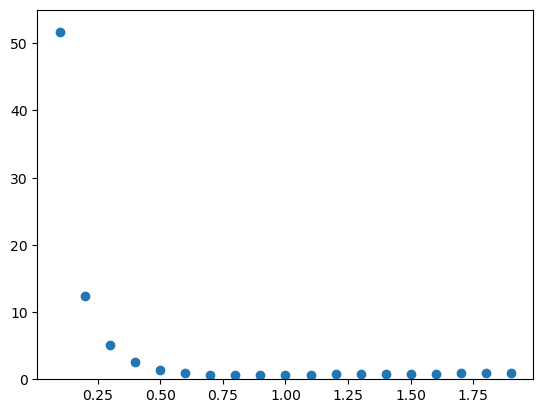

In [ ]:
a = np.arange(0, 2, .1)
plot_vals = np.zeros_like(a)
plot_vals_2 = np.zeros_like(a)
for ind, a_val in enumerate(a):
    plot_vals[ind] = np.nanmean(
        np.abs(a_val**2.0 * data_single_freq.data_array - model_single_freq.data_array)
    )
    plot_vals_2[ind] = np.nanmean(
        np.abs(a_val**2.0 * data_single_freq.data_array - model_single_freq.data_array)
    )/np.nanmean(np.abs(a_val**2.0 * data_single_freq.data_array))
plt.scatter(a, plot_vals)
plt.show()
plt.scatter(a, plot_vals_2)
plt.ylim([0,55])
plt.show()

In [ ]:
model.flag_array = data.flag_array
data.filename=[""]
model.filename=[""]
diff = data.sum_vis(
    model,
    difference=True,
    inplace=False,
    override_params=[
        "earth_omega",
        "timesys",
        "uvw_array",
        "dut1",
        "gst0",
        "nsample_array",
        "phase_center_catalog",
        "phase_center_app_ra",
        "phase_center_app_dec",
        "lst_array",
        "telescope",
        "rdate",
        "filename",
        "phase_center_id_array",
        "time_array",
        "vis_units"
    ],
)

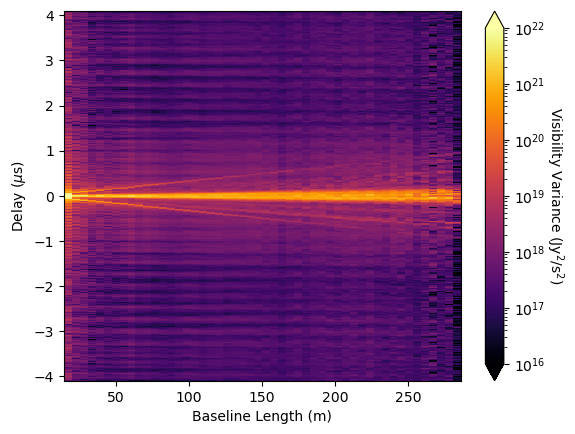

In [ ]:
plot_delay_spectra.plot_visibilities(diff)

In [ ]:
data_abscal = pyuvdata.UVData()
data_abscal.read(
    "/safepool/rbyrne/hera_cal_testing_Sept2024/zen.2459861.45004_abscal.uvfits"
)
data_abscal.select(times=use_time, polarizations=use_pols)
data_abscal.inflate_by_redundancy(use_grid_alg=True)
data_abscal.conjugate_bls()
data_abscal.select(bls=use_baselines)
data_abscal.reorder_blts()
data_abscal.reorder_pols(order="AIPS")
data_abscal.reorder_freqs(channel_order="freq")

Missing some redundant groups. Filling in available data.


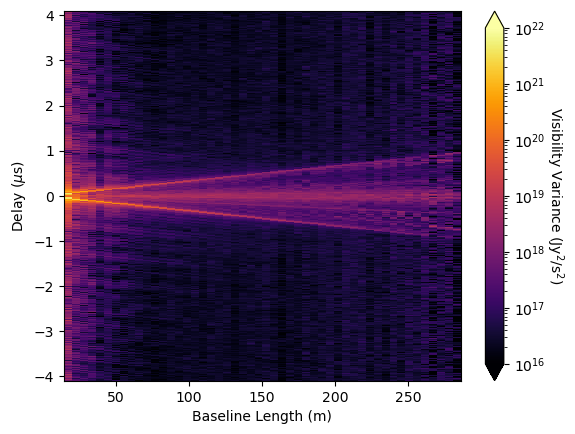

In [ ]:
plot_delay_spectra.plot_visibilities(data_abscal)

In [ ]:
data_abscal.data_array[np.where(data_abscal.flag_array)] = np.nan

Mean of empty slice
Mean of empty slice


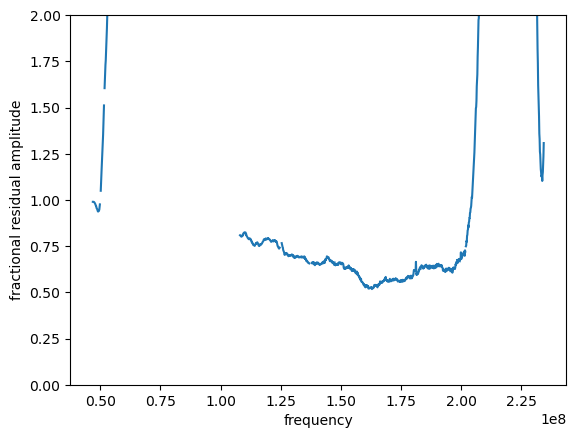

In [ ]:
plt.plot(
    data.freq_array,
    np.nanmean(np.abs(data_abscal.data_array - model.data_array), axis=(0, 2))
    / np.nanmean(np.abs(data_abscal.data_array), axis=(0, 2)),
)
plt.xlabel("frequency")
plt.ylabel("fractional residual amplitude")
plt.ylim([0, 2])
plt.show()

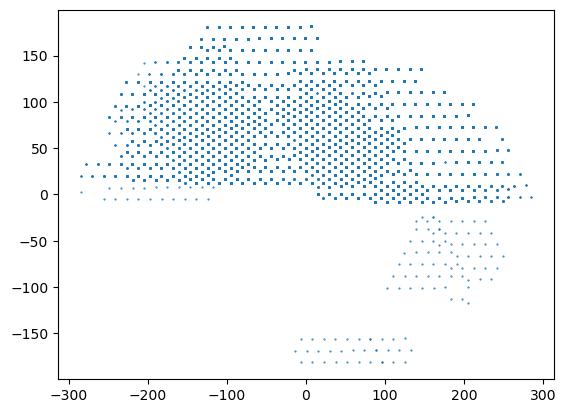

In [ ]:
plt.scatter(data.uvw_array[:, 0], data.uvw_array[:, 1], 1, marker=".")
plt.show()

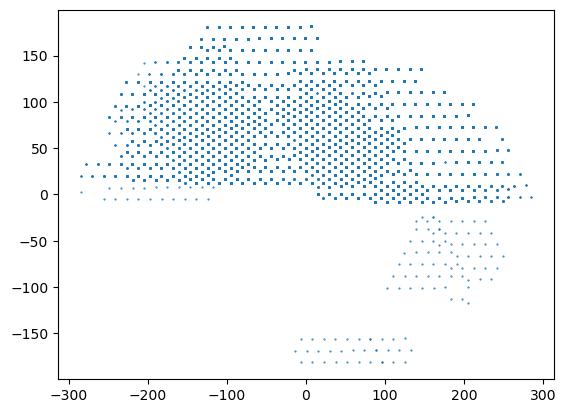

In [ ]:
data_copy = data.copy()
data_copy.set_uvws_from_antenna_positions()
plt.scatter(data_copy.uvw_array[:, 0], data_copy.uvw_array[:, 1], 1, marker=".")
plt.show()

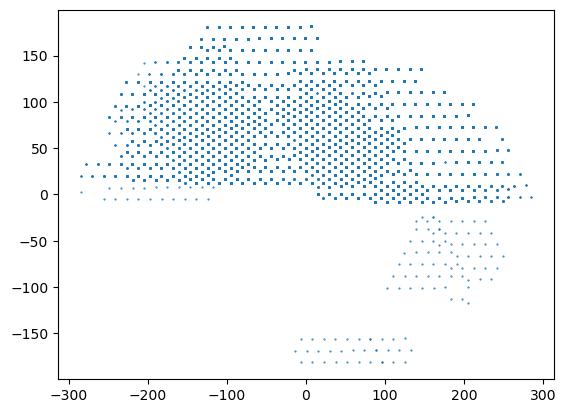

In [ ]:
plt.scatter(model.uvw_array[:, 0], model.uvw_array[:, 1], 1, marker=".")
plt.show()

In [ ]:
model.set_uvws_from_antenna_positions()

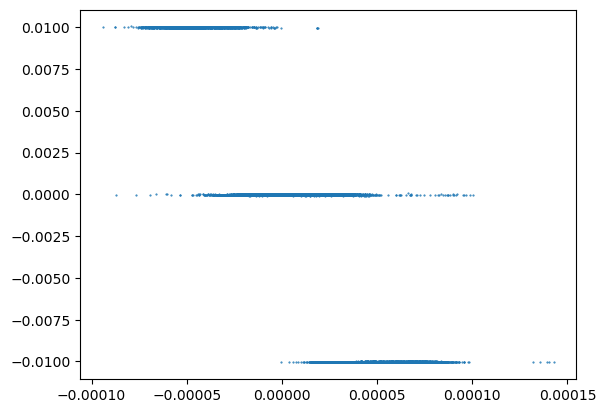

In [ ]:
plt.scatter(
    model.uvw_array[:, 0] - data.uvw_array[:, 0],
    model.uvw_array[:, 1] - data.uvw_array[:, 1],
    1,
    marker=".",
)
plt.show()

In [ ]:
antpos, ants = model.get_ENU_antpos()
print(np.shape(antpos))

(350, 3)


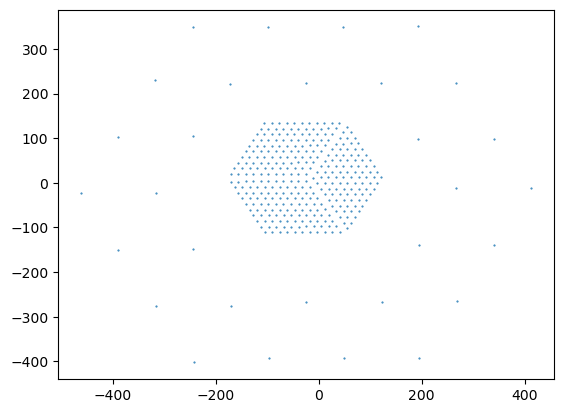

In [ ]:
plt.scatter(antpos[:, 0], antpos[:, 1], 1, marker=".")
plt.show()

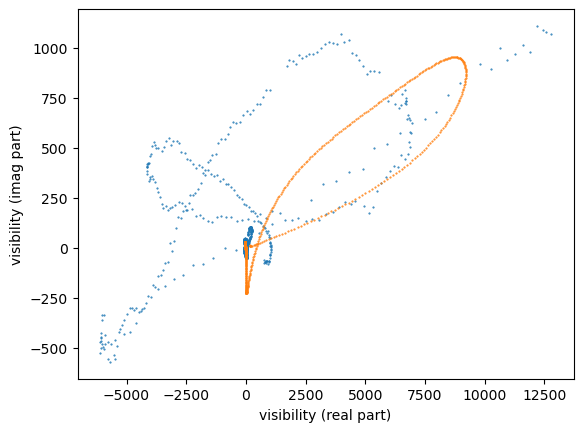

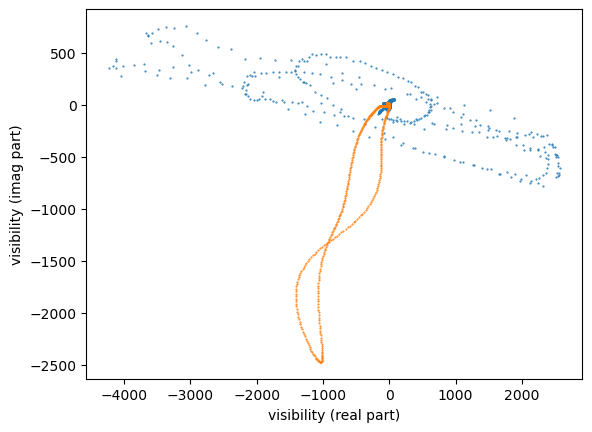

In [ ]:
for use_baseline in range(2):
    plt.scatter(
        np.real(data.data_array[use_baseline, :, 0]),
        np.imag(data.data_array[use_baseline, :, 0]),
        1,
        marker=".",
    )
    plt.scatter(
        np.real(model.data_array[use_baseline, :, 0]),
        np.imag(model.data_array[use_baseline, :, 0]),
        1,
        marker=".",
    )
    plt.xlabel("visibility (real part)")
    plt.ylabel("visibility (imag part)")
    #plt.xlim([-10000, 10000])
    #plt.ylim([-10000, 10000])
    plt.show()

In [ ]:
print(data.uvw_array[use_baseline, :])
print(model.uvw_array[use_baseline, :])

[ 2.92155823e+01  1.35439187e-01 -9.78489667e-03]
[29.21558327  0.13543816  0.05041565]


In [ ]:
print(list(set(data.ant_1_array)))
print(list(set(data.ant_2_array)))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

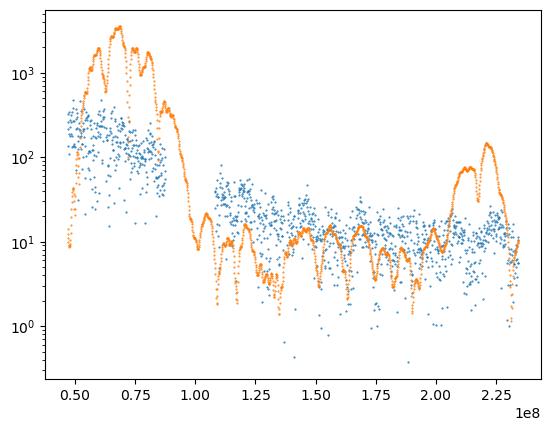

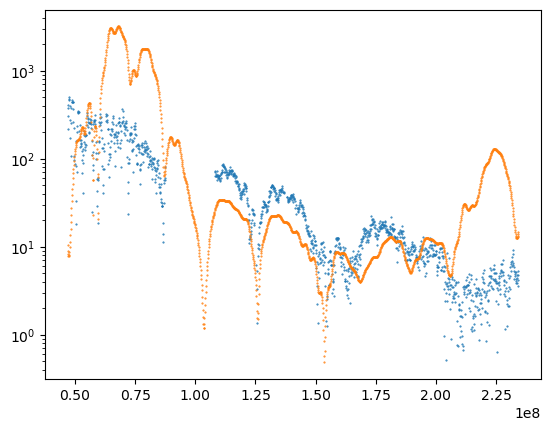

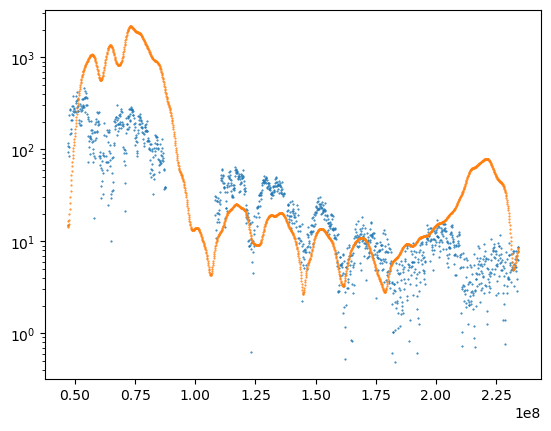

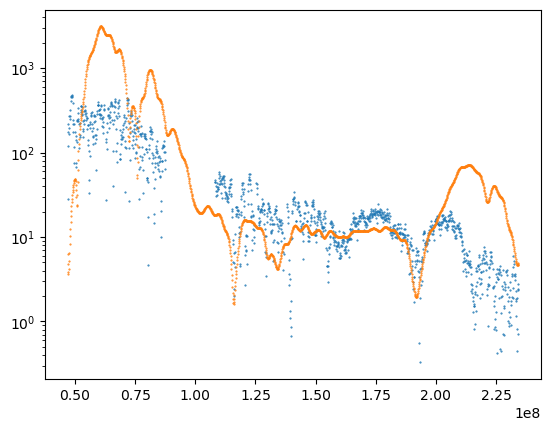

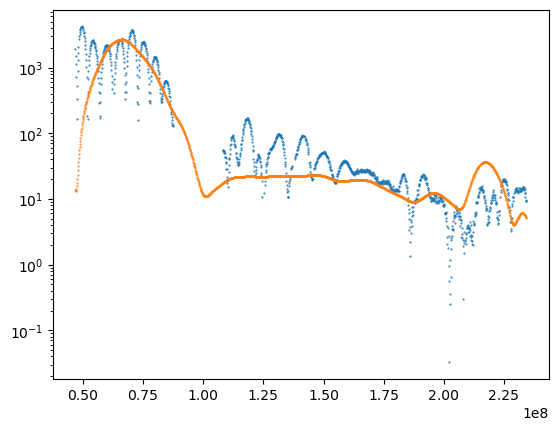

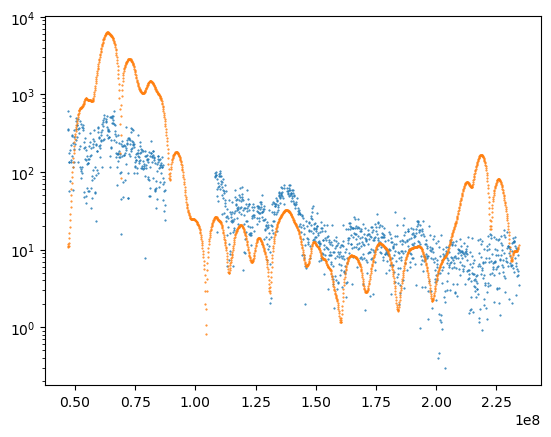

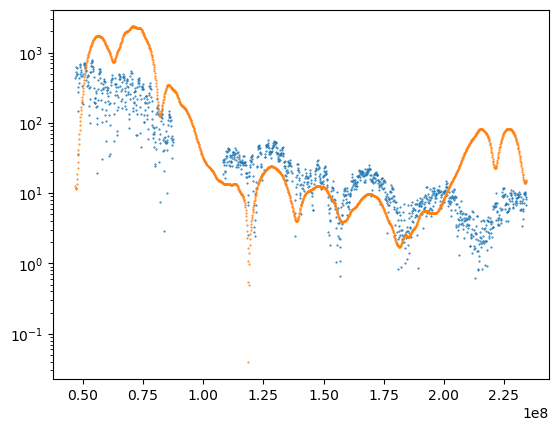

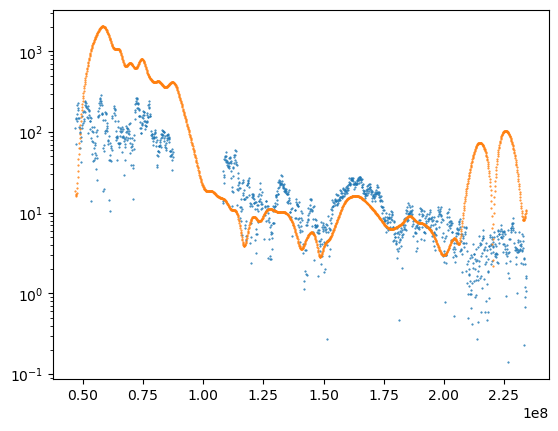

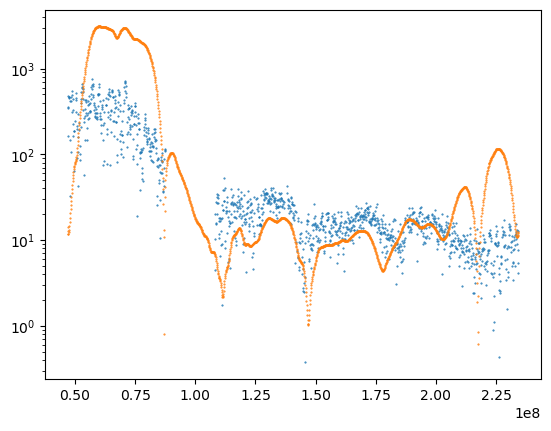

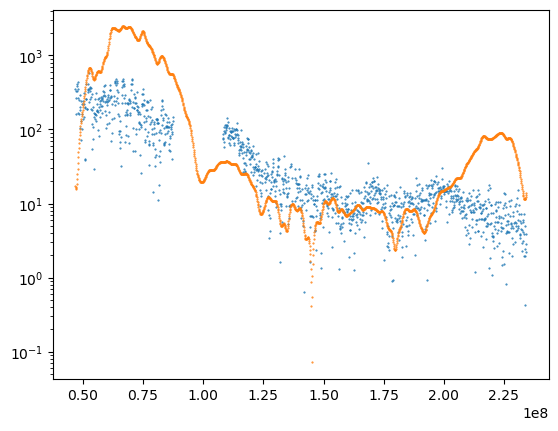

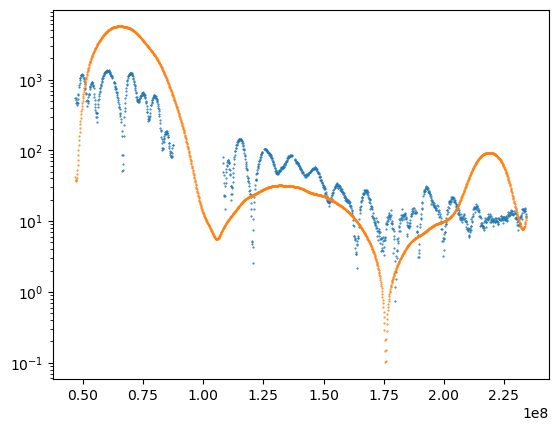

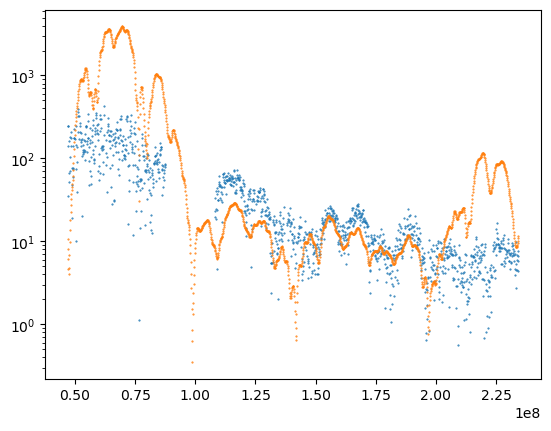

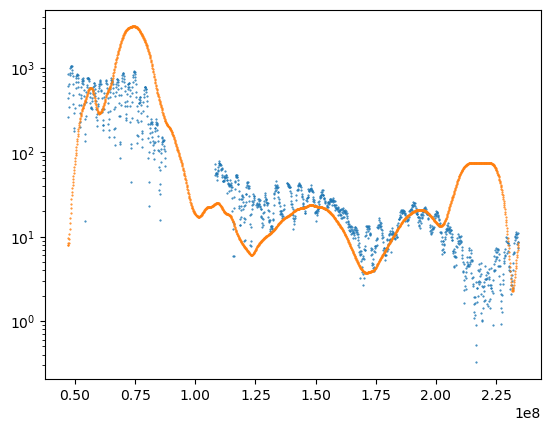

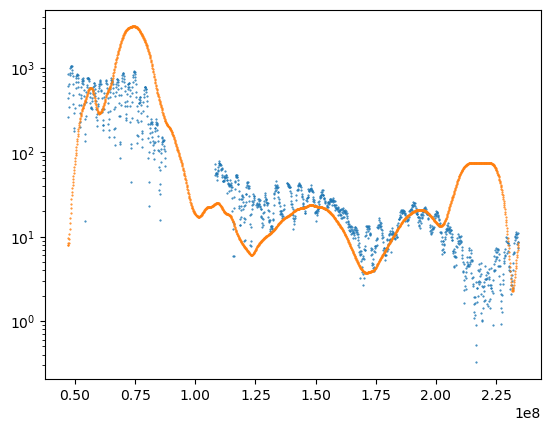

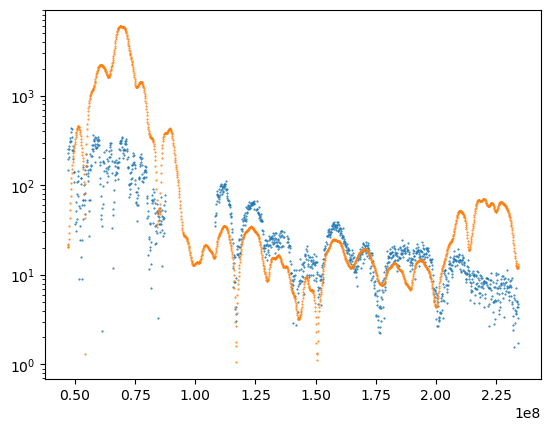

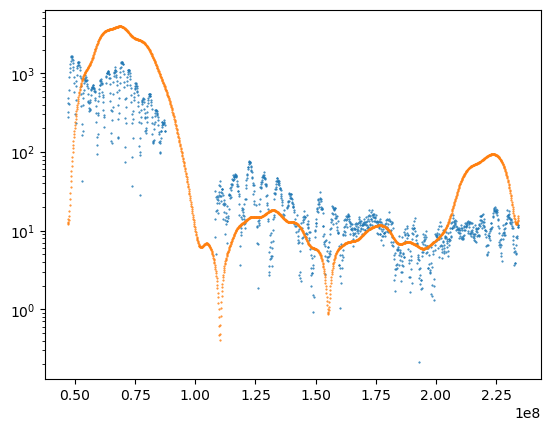

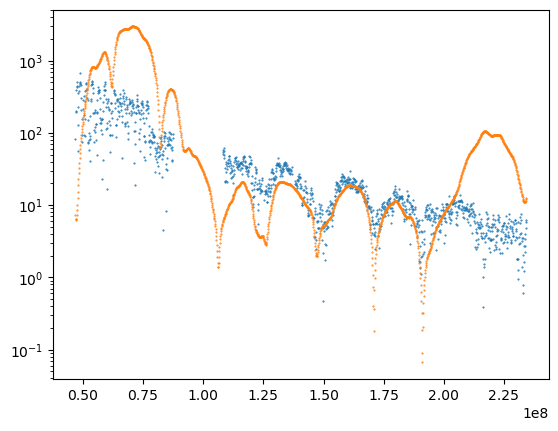

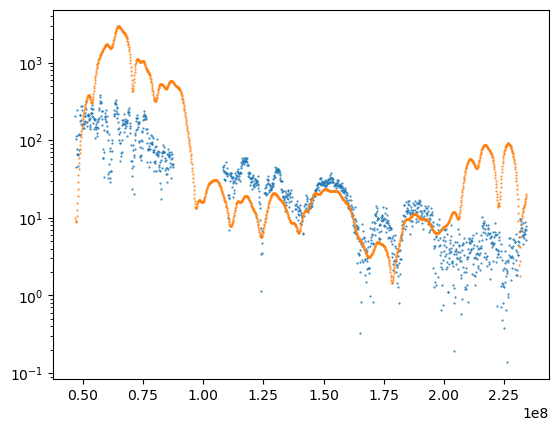

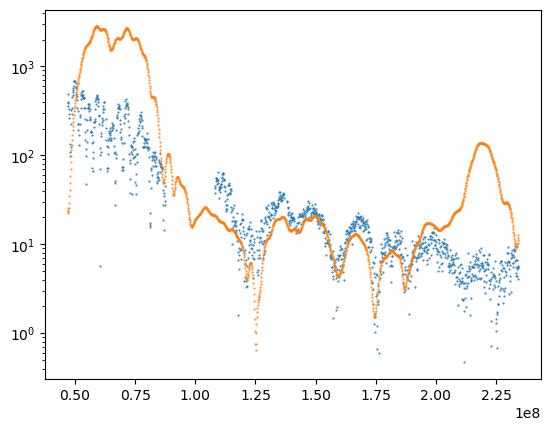

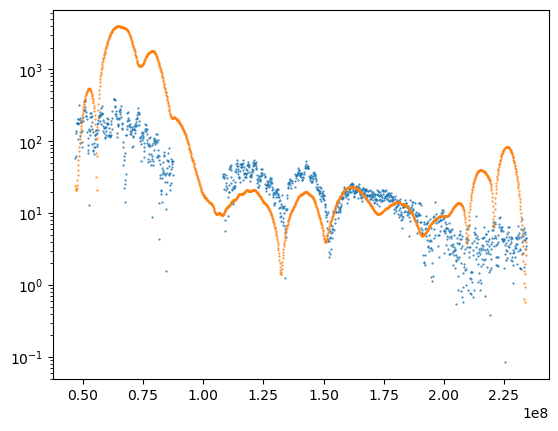

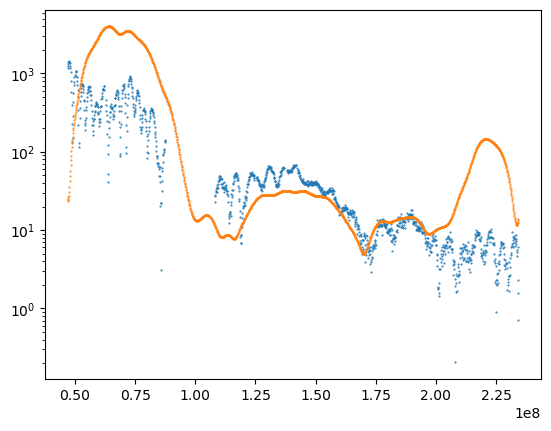

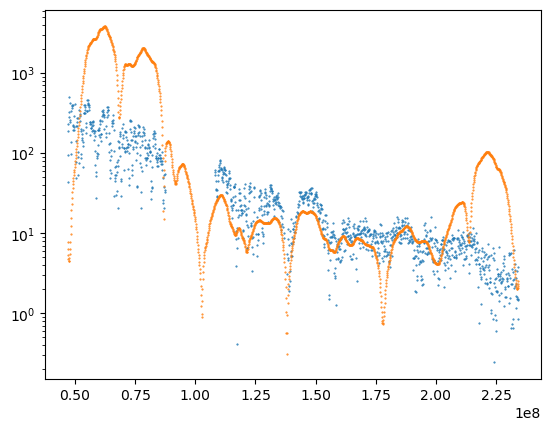

KeyboardInterrupt: 

In [ ]:
baselines = list(set(zip(data.ant_1_array, data.ant_2_array)))
for bl in baselines[0:100]:
    data_copy = data.copy()
    data_copy.select(bls=bl)
    model_copy = model.copy()
    model_copy.select(bls=bl)
    plt.scatter(
        data_copy.freq_array,
        np.abs(data_copy.data_array[0, :, 0]),
        1,
        marker=".",
    )
    plt.scatter(
        model_copy.freq_array,
        np.abs(model_copy.data_array[0, :, 0]),
        1,
        marker=".",
    )
    plt.yscale("log")
    plt.show()

In [ ]:
#data.compress_by_redundancy(use_grid_alg=True)
#model.compress_by_redundancy(use_grid_alg=True)

Mean of empty slice
Mean of empty slice


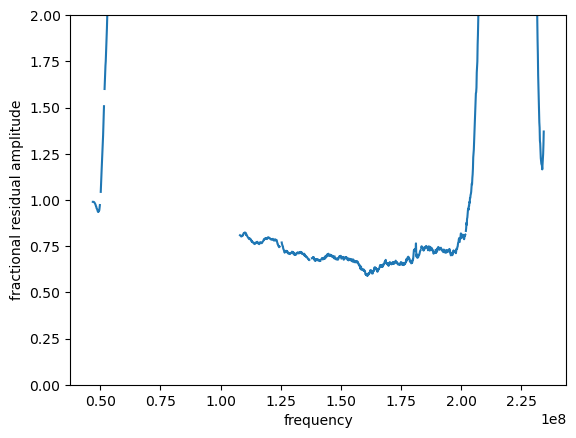

In [ ]:
plt.plot(
    data.freq_array,
    np.nanmean(np.abs(data.data_array - model.data_array), axis=(0, 2))
    / np.nanmean(np.abs(data.data_array), axis=(0, 2)),
)
plt.xlabel("frequency")
plt.ylabel("fractional residual amplitude")
plt.ylim([0, 2])
plt.show()

In [ ]:
model.get_data((160, 110))

array([[[ 6.04671164-8.99487863j,  6.1319312 -8.12529098j],
        [ 6.53705467-7.74646376j,  7.15335337-7.2058988j ],
        [ 7.23508624-6.86335494j,  8.41946199-6.58392513j],
        ...,
        [-1.61275825+2.3278778j , -1.96211253+1.65010851j],
        [-1.41024119+2.78067081j, -2.17988059+1.81719376j],
        [-1.20776444+3.31399994j, -2.42309156+1.97501464j]]])

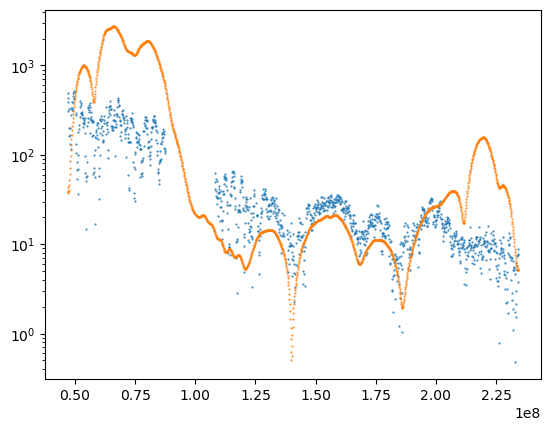

In [ ]:
plt.scatter(
    data_copy.freq_array,
    np.abs(data_copy.data_array[0, :, 0]),
    1,
    marker=".",
)
plt.scatter(
    model_copy.freq_array,
    np.abs(model_copy.data_array[0, :, 0]),
    1,
    marker=".",
)
plt.yscale("log")
plt.show()

In [ ]:
def get_antenna_pair_from_baseline_nums(baseline_nums):
    ant2 = (baseline_nums - 2**16) % 2048
    ant1 = [int(value) for value in (baseline_nums - 2**16 - ant2) / 2048]
    return list(zip(ant1, ant2))

In [ ]:
data.conjugate_bls()
data.inflate_by_redundancy(use_grid_alg=True)
red_baselines, _, _, conj_red_baselines = data.get_redundancies(
    include_conjugates=True
)
data.compress_by_redundancy()

red_groups_data = np.full((data.Nbls), np.nan, int)
for bl_ind, baseline in enumerate(
    list(zip(data.ant_1_array, data.ant_2_array))
):
    for red_ind, red_group in enumerate(red_baselines):
        red_group_ants = get_antenna_pair_from_baseline_nums(
            np.array(red_group)
        )
        if baseline in red_group_ants:
            red_groups_data[bl_ind] = red_ind
        elif baseline[::-1] in red_group_ants:
            ant1 = data.ant_2_array[bl_ind]
            ant2 = data.ant_1_array[bl_ind]
            data.baseline_array[bl_ind] = 2048 * ant1 + ant2 + 2**16
            data.data_array[bl_ind, :, :] = np.conj(
                data.data_array[bl_ind, :, :]
            )
            data.ant_1_array[bl_ind] = ant2
            data.ant_2_array[bl_ind] = ant1
            red_groups_data[bl_ind] = red_ind

red_groups_model = np.full((model.Nbls), np.nan, int)
for bl_ind, baseline in enumerate(
    list(zip(model.ant_1_array, model.ant_2_array))
):
    for red_ind, red_group in enumerate(red_baselines):
        red_group_ants = get_antenna_pair_from_baseline_nums(
            np.array(red_group)
        )
        if baseline in red_group_ants:
            red_groups_model[bl_ind] = red_ind
            continue
        elif baseline[::-1] in red_group_ants:
            ant1 = model.ant_2_array[bl_ind]
            ant2 = model.ant_1_array[bl_ind]
            model.baseline_array[bl_ind] = 2048 * ant1 + ant2 + 2**16
            model.data_array[bl_ind, :, :] = np.conj(
                model.data_array[bl_ind, :, :]
            )
            model.ant_1_array[bl_ind] = ant2
            model.ant_2_array[bl_ind] = ant1
            red_groups_model[bl_ind] = red_ind
            continue

use_red_groups = [
    group for group in red_groups_data if group in red_groups_model
]
use_data = np.zeros(
    (len(use_red_groups), data.Nfreqs, data.Npols), dtype=complex
)
use_model = np.zeros(
    (len(use_red_groups), data.Nfreqs, data.Npols), dtype=complex
)
for group_ind, group in enumerate(use_red_groups):
    use_data[group_ind, :, :] = data.data_array[
        np.where(red_groups_data == group)[0], :, :
    ]
    use_data[
        np.where(data.flag_array[np.where(red_groups_data == group)[0], :, :])
    ] = (np.nan + 1j * np.nan)
    use_model[group_ind, :, :] = model.data_array[
        np.where(red_groups_model == group)[0], :, :
    ]
    use_model[
        np.where(data.flag_array[np.where(red_groups_data == group)[0], :, :])
    ] = (np.nan + 1j * np.nan)

plt.scatter(np.real(use_data), np.imag(use_data), marker=".")
plt.scatter(np.real(use_model), np.imag(use_model), marker=".")
plt.xlabel("visibility (real part)")
plt.ylabel("visibility (imag part)")
plt.show()

Missing some redundant groups. Filling in available data.
The use_grid_alg parameter is not set. Defaulting to True to use the new gridding based algorithm (developed by the HERA team) rather than the older clustering based algorithm. This is change to the default, to use the clustering algorithm set use_grid_alg=False.
invalid value encountered in cast


ValueError: could not broadcast input array from shape (281,1536,2) into shape (1536,2)

In [ ]:
print(np.sort(list(set(data.time_array))))
print(np.sort(list(set(model.time_array))))

[2459861.44998783]
[2459861.44998783]


In [ ]:
len(data.freq_array)

1536

In [ ]:
len(model.freq_array)

1536